# 【問題1】SVM分類器のクラスを作成する
# 【問題2】（アドバンス課題）多項式カーネル関数の作成

In [14]:
import numpy as np

class ScratchSVMClassifier():
    """
    SVM分類器のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    c : float
      閾値
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録

    """

    
    def __init__(self, num_iter=1200, lr=1e-4, c=1e-5, kernel='linear', gamma=1,degree=1,  no_bias=False, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        # 学習率
        self.lr = lr
        # 閾値
        self.c = c
        # カーネルの種類
        self.kernel = kernel
        # gamma(初期値1)
        self.gamma = gamma
        # 多項式の場合の数
        self.degree = degree
        # 各種スイッチ
        self.no_bias = no_bias
        self.verbose = verbose
        # 損失を記録する配列を用意
        self.loss = np.zeros(self.iter)
        self.val_loss = np.zeros(self.iter)
        # バイアス(初期値0)
        self.intercept_ = 0
        # 重みを格納する配列
        self.coef_ = np.array([])
        # rambdaを格納する配列
        self.lmd_ = np.array([])
        # サポートベクターのインデックスを格納する配列
        self.support_vector_index = np.array([])
        # サポートベクターを格納する配列
        self.support_vectors_ = np.array([])
        

    def fit(self, X, y):
        """
        SVM分類器を学習する。検証用データが入力された場合はそれに対する損失と精度もイテレーションごとに計算する。

          Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        """
        
        # 次元数を必要に応じて追加
        if X.ndim < 2:
            X = X[:, np.newaxis]
        if y.ndim < 2:
            y = y[:, np.newaxis]

        # Xの行数を代入
        X_rows_cnt  = np.shape(X)[0]

        # ラグランジュ乗数を乱数で初期化
        self.lmd_ = np.random.rand(X_rows_cnt)[:, np.newaxis]
        
        # カーネル関数コール
        k = self._kernel_func(X)
        
        for i in range(self.iter):
            # 最急降下法関数コール
            self._gradient_descent(y, k, X_rows_cnt)
        
        # 最適化したlambdaを元に閾値以下のものをサポートベクターにする
        self.support_vector_index = np.where(self.lmd_ > self.c)[0]
        self.support_vectors_ = X[self.support_vector_index, :]
        
        # 分類境界線計算関数コール
        self._calc_boundary(y)
        
            
    def _kernel_func(self, X):
        """
        Xのカーネル関数

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ

        Returns
        -------
        k : 次の形のndarray, shape (n_samples, n_samples)
            Xのカーネル
        """

        k = self.gamma * (np.dot(X, X.T) + self.intercept_) ** self.degree
        
        return k 
        
    
    def _gradient_descent(self, y, k, X_rows_cnt):
        """
        最急降下法により、パラメータを更新する

        Parameters
        ----------
        y: 次の形のndarray, shape (n_samples, 1)
          検証データ
        k : 次の形のndarray, shape (n_samples, n_samples)
        　　Xのカーネル
        X_rows_cnt　: int
          Xの行数
        """
        
        # 項の一部を計算
        y_dot = np.dot(y, y.T)
        y_k = y_dot * k
        term = np.dot(y_k, self.lmd_)

        # 勾配を求める
        gradient = 1 - term

        self.lmd_ += self.lr * gradient
        
        self.lmd_ = np.where(self.lmd_ < 0, 0, self.lmd_)
            
            
    def _calc_boundary(self, y):    
        """
        分類境界線を算出する

        Parameters
        ----------
        y: 次の形のndarray, shape (n_samples, 1)
          検証データ
        """

        # サポートベクターのインデックスと一致するyを抜き出す
        y = y[self.support_vector_index]
        
        # サポートベクターのインデックスと一致するrambdaを抜き出す
        lmd = self.lmd_[self.support_vector_index]
        
        # thetaの計算式
        self.coef_ = lmd * y * self.support_vectors_
        
        # theta.T + X
        theta_T_X = np.dot(self.support_vectors_, self.coef_.T)
        
        # theta0の計算しき
        self.intercept = (y - np.sum(theta_T_X, axis=1)[:, np.newaxis]) / len(self.support_vector_index)
            
        self.coef_ = np.sum(self.coef_, axis=0)
        
            
    def predict(self, X):
        """
        SVM分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            線形回帰による推定結果
        """
        
        # バイアス入れないフラグが立っていない場合は、バイアス項を1で先頭列に挿入
        if self.no_bias is False:
            # TODO:uniqueなラベルにする
            y_pred = np.where(np.dot(X, self.coef_) + self.intercept_ > 0, 1, -1)
        else:
            y_pred = np.where(np.dot(X, self.coef_) > 0, 1, -1)
        
        return y_pred

In [15]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [16]:
ssvc = ScratchSVMClassifier()
ssvc.fit(X_train, y_train)

# 【問題3】指標値の算出
* 混同行列
* 確実性

In [17]:
y_pred = ssvc.predict(X_test)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))

[[62  0]
 [ 0 63]]
1.0


# 【問題4】決定領域の可視化

In [18]:
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def decision_region(X_train, y_train, model, target_names, resolution=0.01, threshold=0.5, alpha=0.5):
    """
    ２値分類を２次元の特徴量で学習したモデルの決定領域を描く
    背景の色が学習したモデルによる推定値から描画される
    散布図の点は学習用のデータである。
    
    Parameters
    ---------------
    X_train: ndarray, shape(n_samples, 2)
        学習用データの特徴量
    y_train: ndarray, shape(n_samples,)
        学習用データの正解値
    model: object
        学習したモデルのインスタンスを入れる
    step: float, (default: 0.1)
        推定値を計算する間隔を設定する
    title: str
        グラフのタイトルの文章を与える
    xlabel, ylabel: str
        軸ラベルの文章を与える
    target_names=: list of str
        凡例の一覧を与える
    ---------------
    """
    # setting
    markers = ('>', '<')
    scatter_colors = ['red', 'blue']
    cmap = ListedColormap(('pink', 'skyblue'))
    n_class = 2

    # 2変数の入力データの最小値から最大値まで引数resolutionの幅でメッシュを描く
    X1_mesh, X2_mesh = np.meshgrid(np.arange(np.min(X_train[:, 0]) - threshold, np.max(X_train[:, 0]) + threshold, resolution), np.arange(np.min(X_train[:, 1]) - threshold, np.max(X_train[:, 1]) + threshold, resolution))

    # 予想結果を元のグリッドポイントのデータサイズに変換
    mesh = np.c_[np.ravel(X1_mesh), np.ravel(X2_mesh)]
    z = model.predict(mesh).reshape(X1_mesh.shape)
    
    # メッシュデータと分離クラスを使って決定境界を描いている
    plt.contourf(X1_mesh, X2_mesh, z, n_class-1, cmap=cmap)
    plt.xlim(X1_mesh.min(), X1_mesh.max())
    plt.ylim(X2_mesh.min(), X2_mesh.max())
    
    for i, target in enumerate(set(np.unique(y_train))):
        plt.scatter(X_train[y_train==target][:, 0], X_train[y_train==target][:, 1], s=80, color=scatter_colors[i], label=target_names[i], marker=markers[i])
        patches = [mpatches.Patch(color=scatter_colors[i], label=target_names[i]) for i in range(n_class)]
        plt.legend(handles=patches)
        plt.legend()
        plt.show
        
    # サポートベクトルを描画
    for n in ssvc.support_vectors_:
        plt.scatter(n[0], n[1], s=200, c='limegreen', marker='*')
        plt.show

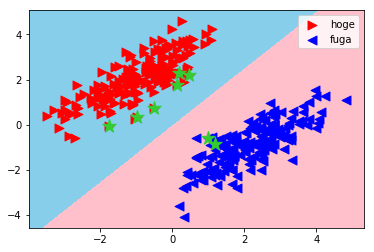

In [6]:
decision_region(X_train, y_train, ssvc, target_names=['hoge', 'fuga'])
# 星がサポートベクター

# 【問題5】時間の計測
* 時間かかってるやつはどれか(predictはやらない)

In [7]:
    def _gradient_descent(y, k, X_rows_cnt):
        """
        最急降下法により、パラメータを更新する

        Parameters
        ----------
        y: 次の形のndarray, shape (n_samples, 1)
          検証データ
        k : 次の形のndarray, shape (n_samples, n_samples)
        　　Xのカーネル
        X_rows_cnt　: int
          Xの行数
        """
        
        lmd = np.ones(X_rows_cnt)[:, np.newaxis]
        
        for i in range(X_rows_cnt):
            # 初期化
            g = 0
            for j in range(X_rows_cnt):
                # j方向に更新式の一部を計算し、積み上げてく
                g += lmd[j] * y[i] * y[j] * k[i, j]
            
            # 最急降下法により、lambdaを更新
            lmd[i] += 0.1 * (1- g)
            
            # rambdaが0以下の場合は0
            if lmd[i] < 0:
                lmd[i] = 0

In [8]:
    def _calc_boundary(y):    
        """
        分類境界線を算出する

        Parameters
        ----------
        y: 次の形のndarray, shape (n_samples, 1)
          検証データ
        """
        
        # サポートベクターのインデックスと一致する行を抜き出す
        y = y[ssvc.support_vector_index, np.newaxis]
        lmd = ssvc.lmd_[ssvc.support_vector_index]
        
        # thetaの計算式
        coef_ = lmd * y * ssvc.support_vectors_
        
        # theta.T + X
        theta_T_X = np.sum(np.dot(ssvc.support_vectors_, coef_.T), axis=1)
        
        # theta0の計算しき
        intercept = np.sum(y.ravel() - theta_T_X) / len(ssvc.support_vector_index)
            
        coef_ = np.sum(ssvc.coef_, axis=0)

In [9]:
import time

# カーネル関数
def _calc_kernel(X):
    return np.dot(X, X.T)


k = _calc_kernel(X_train)

x_rows = len(X_train)

sv_index = ssvc.support_vector_index

t0 = time.time()
_gradient_descent(y_train, k, x_rows)
t1 = time.time()
print('time : {}s'.format(t1-t0))
t0 = time.time()
_calc_boundary(y_train)
t1 = time.time()
print('time : {}s'.format(t1-t0))

time : 1.0276610851287842s
time : 0.0006940364837646484s


明らかに更新式なので改善  
for文2回ループがイケてなさそう  
→ ブロードキャスト化できないか

In [10]:
def _gradient_descent(y, k, X_rows_cnt):
    """
    最急降下法により、パラメータを更新する

    Parameters
    ----------
    y: 次の形のndarray, shape (n_samples, 1)
      検証データ
    k : 次の形のndarray, shape (n_samples, n_samples)
      Xのカーネル
    X_rows_cnt　: int
      Xの行数
    """

    lmd = np.ones(X_rows_cnt)[:, np.newaxis]
    
    term = np.sum((y * k * lmd), axis=1)[:, np.newaxis]

    # 最急降下法により、lambdaを更新
    gradient =  (y * term)
    
    lmd += 0.1 * (1 -gradient)
    lmd = np.where(lmd < 0, 0, lmd)


In [11]:
k = _calc_kernel(X_train)

t0 = time.time()
_gradient_descent(y_train[:, np.newaxis], k, x_rows)
t1 = time.time()
print('time : {}s'.format(t1-t0))

time : 0.0029909610748291016s


早くなった。採用

# 【問題6】ロジスティック回帰とSVM
### ロジスティック回帰とSVMは本質的に何が異なっているか
- 境界線の求め方が異なる  
    ロジスティック回帰： ロジスティック曲線を求める(シグモイドなど)  
    SVM : 境界線を求め、一番近いサンプルデータまでのマージンの和を最大にし、境界線とする

In [12]:
#もがいたあと

In [13]:
# カーネル関数
def _calc_kernel(X):
    return np.dot(X, X.T)
hoge = ssvc.support_vectors_
k = _calc_kernel(X)
lmd = ssvc.lmd_
sv_index = ssvc.support_vector_index -1
# 目的関数
def _calc_boundary(X, y, lmd, sv_index):
    y = y[sv_index, np.newaxis]
    lmd = lmd[sv_index+1]
    
   # thetaの計算式
    theta = lmd * y * np.sum(X)
    
    theta_t_x = np.dot(X, theta)
    print(theta_t_x)
    print(y)
    print(y-theta_t_x)
    # theta0の計算式
    intercept = np.sum(y - (theta_t_x)) / len(sv_index)
    
    return theta, intercept
    
theta_t_x, intercept = _calc_boundary(hoge, y_train, lmd, sv_index)
print(theta)
print(intercept)
"""

"""

ValueError: shapes (8,2) and (8,1) not aligned: 2 (dim 1) != 8 (dim 0)

In [ ]:
import matplotlib.pyplot as plt
# カーネル関数
def _calc_kernel(X):
    return np.dot(X, X.T)

k = _calc_kernel(X)
lmd = ssvc.lmd_
sv = ssvc.support_vectors_

# 目的関数
"""
def _calc_boundary(X, y, k, sv, lmd):    
    X = X[sv, :]
    y = y[sv, np.newaxis]
    lmd = lmd[sv]
    coef_ = np.array([])
    support_vectors_cnt = len(sv)
    print(X)
    print(y.shape)
    
    
    # thetaの計算式
    coef_ = lmd * y * np.sum(X)
    print(coef_.T.shape)
    # theta0の計算式
    intercept_ = np.sum(y - (np.dot(coef_.T, X))) / support_vectors_cnt
    print(coef_)
    print(support_vectors_cnt)
    print(intercept_)
    
    return np.sum(np.dot(coef_.T, X))
    
print(_calc_boundary(X, y, k, sv, lmd))
"""
# サポートベクトルを描画
for n in sv:
    print(n)
    plt.scatter(n[1], n[2], s=80, c='r', marker='o')

# 星可愛い
plt.scatter(X_train[:, 0], X_train[:, 1], s=80, c='c', marker='*')

In [ ]:
    def predict(X, theta, intercept):
        """
        SVM分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
        サンプル

        Returns
        -------
        次の形のndarray, shape (n_samples, 1)
        線形回帰による推定結果
        """
       
        X = np.hstack((np.ones(len(X))[:, np.newaxis], X))
            
        y_pred = np.where(np.dot(X, theta) + intercept > 0, 1, -1)
        
        return y_pred
    
y_pred = predict(X_test, theta, intercept)
 
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score

print(accuracy_score(y_test, y_pred))